### import libraries

In [1]:
import torch
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, utils

## Generator

In [2]:
class G(nn.Module):
    def __init__(self, latent):
        super(G, self).__init__()
        self.ngf = 32
        self.latent = latent
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.latent, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

## Descriminator

In [3]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.ndf = 32
        self.main = nn.Sequential(
            nn.Conv2d(3, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

## Data Visualization

In [4]:
img = Image.open('./data64/000.jpg')

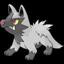

In [5]:
img

In [6]:
img.size

(64, 64)

### Data Handler

In [7]:
class DataReader(Dataset):
    def __init__(self, root_dir):
        self.root = root_dir
        self.tform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(os.listdir(self.root))

    def __getitem__(self, idx):
        imname = str(idx).zfill(3) + '.jpg'
        impath = os.path.join(self.root, imname)
        return self.tform(Image.open(impath))


### hyper parameters

In [8]:
epochs = 1000
lr = 0.0003
torch.manual_seed(1)
batch_size = 64
log_interval = 200
latent_size = 100

#### Initialization

#### Data Loader

In [9]:
dataset = DataReader('./data64')
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

#### Models

In [10]:
discriminator = D()
generator = G(latent_size)

#### loss

In [11]:
# loss(o, t) = - 1/n \sum_i (t[i] log(o[i]) + (1 - t[i]) log(1 - o[i]))
loss = nn.BCELoss(size_average=True)

#### Cuda

In [12]:
cuda_enabled = torch.cuda.is_available()

In [13]:
if cuda_enabled:
    print('CUDA device found and active')
    discriminator.cuda()
    generator.cuda()
    loss.cuda()


CUDA device found and active


#### Optimizer

In [14]:
# optimizers
optimD = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
optimG = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))

### Create noise signal

In [15]:
test_noise = torch.Tensor(batch_size, latent_size, 1, 1).normal_(0, 1)
if cuda_enabled:
    test_noise = test_noise.cuda()

test_noiseV = Variable(test_noise)

## Train the model

In [16]:
for i in range(1, epochs+1):
    for j, data in enumerate(dataloader):
        latent = torch.Tensor(data.size(0), latent_size, 1, 1)
        label = torch.Tensor(data.size(0), 1, 1, 1)

        if cuda_enabled:
            latent = latent.cuda()
            label = label.cuda()
            data = data.cuda()
            
        # train discriminator
        # train on real images
        # label 0 -> fake, label 1 -> real
        optimD.zero_grad()
        real_label = Variable(label.fill_(1), requires_grad=False)
        real_img = Variable(data, requires_grad=False)
        
        # get discriminator output
        out = discriminator(real_img)
        
        # calculate binary cross entropy loss between output and the label
        loss_real = loss(out, real_label)
        
        loss_real.backward()
        
        # train discriminator or on fake images
        noise = Variable(latent.normal_(0, 1), requires_grad=False)
        fake_label = Variable(label.fill_(0), requires_grad=False)
        
        # get fake image from generator
        fake = generator(noise)
        
        # get discrminator loss in detecting fake images
        out = discriminator(fake.detach())
        loss_fake = loss(out, fake_label)
        loss_fake.backward()
        
        # optimize the discriminator
        optimD.step()
        
        # train generator network to creal 'fake' real images
        fake_real_label = Variable(label.fill_(1), requires_grad=False)
        optimG.zero_grad()
        
        # pass teh fake image through discriminator to get the output
        out = discriminator(fake)
        
        # get a loss for how many images  were caught by discriminator
        # more the images caught, higher the loss
        loss_gen = loss(out, fake_real_label)
        loss_gen.backward()
        
        # optimize generator
        optimG.step()
        
        if j % log_interval == 0:
            print('epoch [{}]/[{}]    batch {}    lossD {:.5f}    lossG {:.5f}'.format(
                    i, epochs, j, (loss_real.cpu().data[0] + loss_fake.cpu().data[0]), 
                    loss_gen.cpu().data[0]))

    # save fake images at regular intervals
    if i < 10:
        save_image = True
    elif i < 100 and i % 10 == 0:
        save_image = True
    elif i % 100 == 0:
        save_image = True
    else:
        save_image = False

    if save_image:
        out = generator(test_noiseV).cpu().data
        utils.save_image(out, './fake/fake_epoch' + str(i) + '.jpg', normalize=True)

    torch.save(discriminator, 'dis.pt')
    torch.save(generator, 'gen.pt')

torch.save(discriminator, 'dis.pt')
torch.save(generator, 'gen.pt')
        
    

epoch [1]/[1000]    batch 0    lossD 1.38476    lossG 1.14345


/home/azur/anaconda3/envs/snowflake/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/azur/anaconda3/envs/snowflake/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type G. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch [2]/[1000]    batch 0    lossD 0.61497    lossG 2.28588
epoch [3]/[1000]    batch 0    lossD 0.31809    lossG 3.73152
epoch [4]/[1000]    batch 0    lossD 0.34844    lossG 4.63298
epoch [5]/[1000]    batch 0    lossD 0.40515    lossG 6.19342
epoch [6]/[1000]    batch 0    lossD 1.29543    lossG 6.73075
epoch [7]/[1000]    batch 0    lossD 0.19521    lossG 5.46717
epoch [8]/[1000]    batch 0    lossD 0.63183    lossG 6.89711
epoch [9]/[1000]    batch 0    lossD 0.12262    lossG 4.36641
epoch [10]/[1000]    batch 0    lossD 0.36377    lossG 5.65632
epoch [11]/[1000]    batch 0    lossD 0.18828    lossG 5.13709
epoch [12]/[1000]    batch 0    lossD 0.34978    lossG 7.48862
epoch [13]/[1000]    batch 0    lossD 0.56966    lossG 5.87013
epoch [14]/[1000]    batch 0    lossD 0.94185    lossG 3.67418
epoch [15]/[1000]    batch 0    lossD 1.42209    lossG 5.15816
epoch [16]/[1000]    batch 0    lossD 0.78331    lossG 2.46027
epoch [17]/[1000]    batch 0    lossD 0.70950    lossG 1.75875
